In [1]:
%run flow_tools.py

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from matplotlib.path import Path
from matplotlib import patches

In [3]:
folders = ['/Users/weinberz/Library/CloudStorage/Box-Box/SynCellMotifs/Flow/20230725-TF construct fix/']

In [4]:
df = pd.concat([load_data(folder, colnames = ['WellName', 'CellLine', 'Antibody', 'Media', 'Treatment','Replicate']) 
                for folder in folders], ignore_index=True)

In [5]:
#remove NAs
df2= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

In [6]:
#define gate for FSC-A vs SSC-A
fsc_ssc_verts = [(1e4, 1e4),
              (1e5, 1e4),
              (2.5e5, 1e5),
              (2.5e5, 2.5e5),
              (4e4, 2.5e5),
              (1e4, 5e4),
              (1e4, 5e4),
              (1e4, 1e4)]
fsc_ssc_gate = Path(fsc_ssc_verts)

ssc_verts = [(0, 1e4),
              (2e5, 1.8e5),
              (2.6e5, 1.8e5),
              (2.5e5, 1.7e5),
              (1.25e5, 9e4),
              (1e4, 0),
              (0, 1e4)]
ssc_gate = Path(ssc_verts)

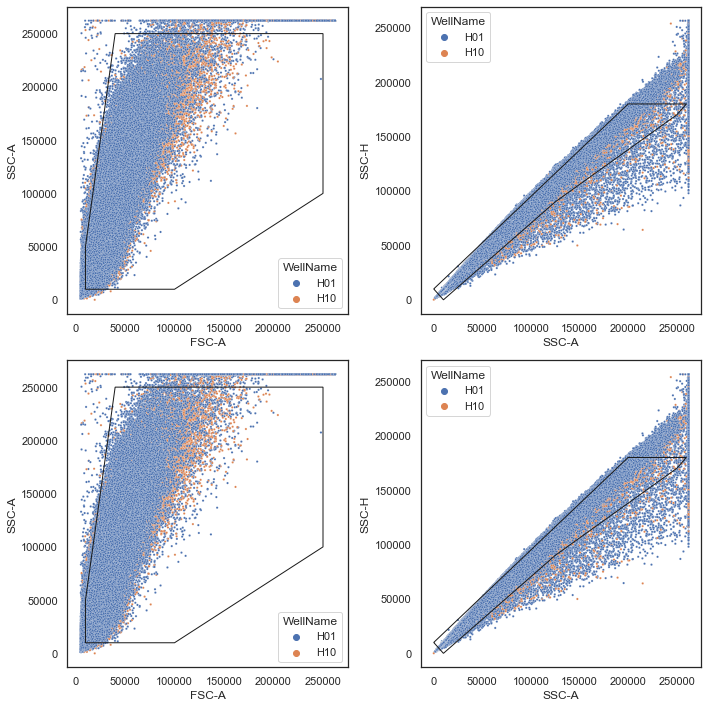

In [7]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['H01','H10']))], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['H01','H10'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['H01','H10'])], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['H01','H10'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[0,0].add_patch(patch)
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[1,0].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[0,1].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[1,1].add_patch(patch)
plt.tight_layout()

In [7]:
#filter to gate
df2 = df2[fsc_ssc_gate.contains_points(df2[['FSC-A','SSC-A']].to_numpy())]
df2 = df2[ssc_gate.contains_points(df2[['SSC-A', 'SSC-H']].to_numpy())]
# # gate on singlets
df2 = gate_density(df2, 0.1, x_var='SSC-A',y_var='SSC-H')

for col in df2.columns:
        if df2[col].dtype=="float32":
            df2["log"+ col]=df2[col].apply(math.log10)

/var/folders/kl/1m52jmh17ldcnypjswtqvg240000gn/T/ipykernel_69159/2748446076.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df2, x='logBUV396-A', shade=True)


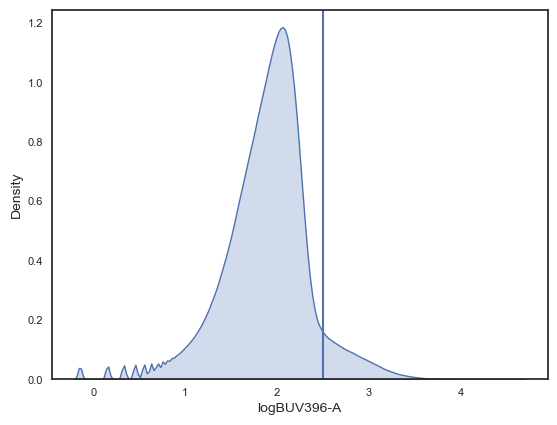

In [9]:
sns.kdeplot(data=df2, x='logBUV396-A', shade=True)
df2 = df2[df2['logBUV396-A'] < 2.5]
plt.axvline(x=2.5)

In [8]:
df2 = df2[df2['logBUV396-A'] < 2]

Text(0.5, 23.999999999999986, 'log <channel>')

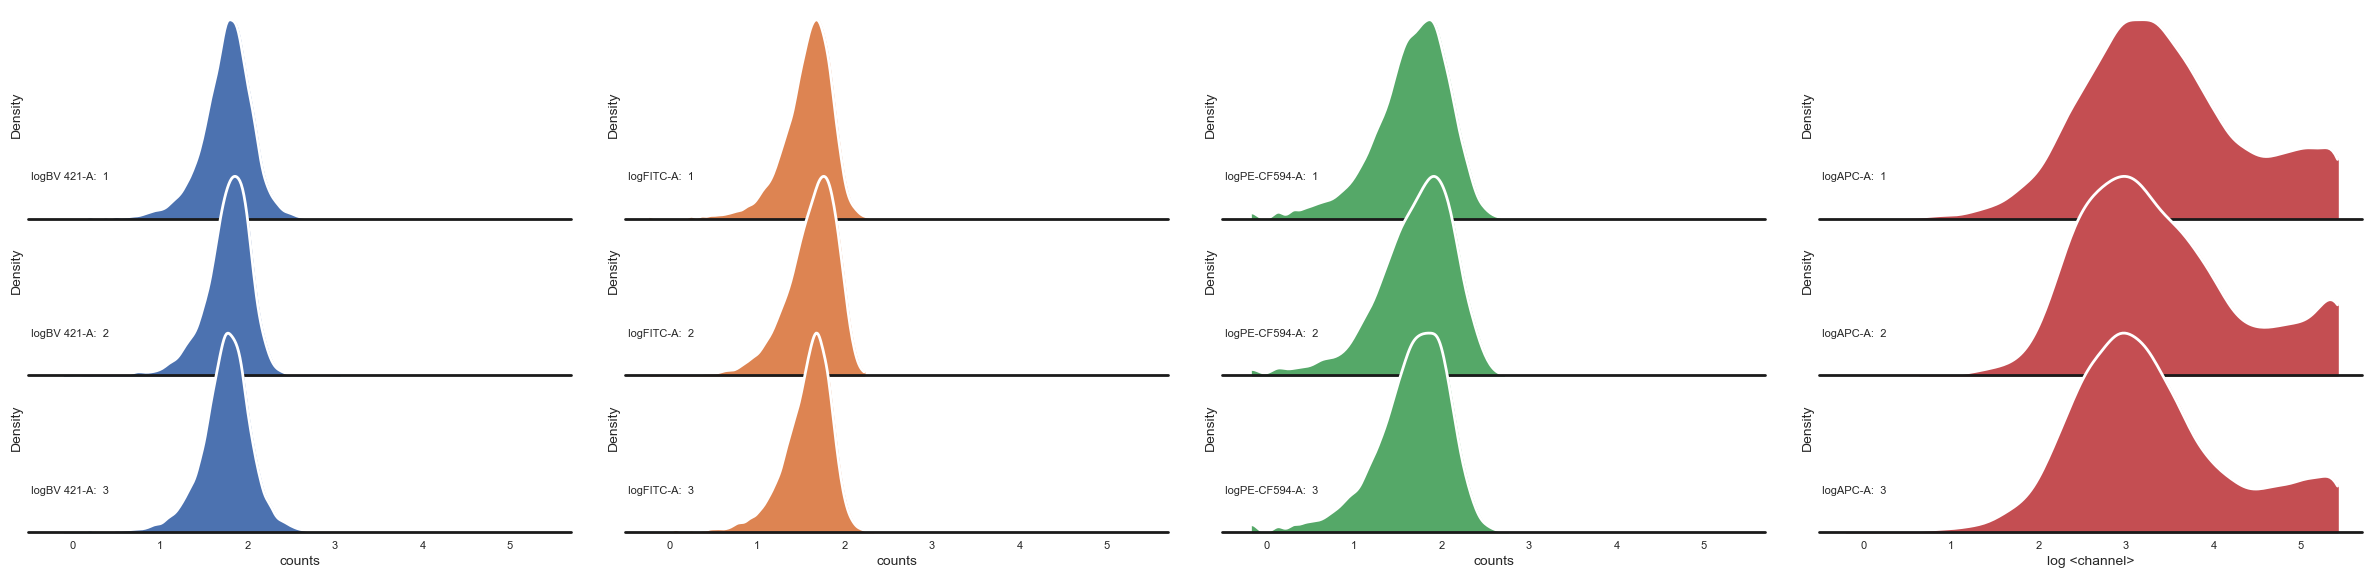

In [18]:
simplified_df = (df2[(df2['CellLine']=='iN') &
                     (df2['Media'] == 'SFES') &
                     (df2['Treatment'] == 'Gal4-VP64')].reset_index()
                 .melt(value_vars=['logBV 421-A', 'logFITC-A', 'logPE-CF594-A','logAPC-A'], 
                       id_vars=['index','Replicate'],
                       var_name='channel',
                       value_name='counts'))

g = sns.FacetGrid(data=simplified_df, 
                  row = 'Replicate', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", fill=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

In [11]:
df2 = df2.replace({'Untransduced': 'Mock'})

In [12]:
df2.Treatment.unique()

array(['Mock', 'Gal4-VP64'], dtype=object)

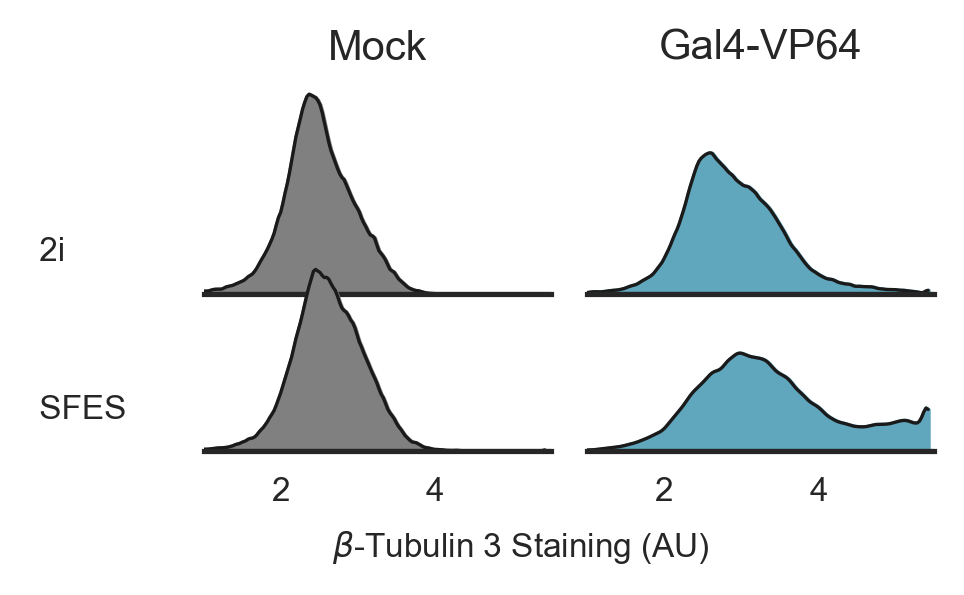

In [13]:
media_order = ['2i', 'SFES']
treatment_order = ['Mock', 'Gal4-VP64']
filters = (df2['CellLine']=='iN')

with sns.color_palette(['gray', '#60A6BD']):
     g = sns.FacetGrid(data=df2[filters], row='Media', col='Treatment', hue='Treatment',
                       col_order=treatment_order, hue_order=treatment_order, row_order=media_order,
                       height=1, aspect=1.5, xlim=[1, 5.5])
g.map(sns.kdeplot, "logAPC-A", fill=True, alpha=1, bw_adjust=.5, clip=None, cut=0)
g.map(sns.kdeplot, "logAPC-A", color="k", lw=.8, bw_adjust=.5, clip=None, cut=0)
g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)
g.tick_params('x',labelsize=SMALL_SIZE)


for ax in g.axes.flat:
    ax.set(facecolor=(0, 0, 0, 0))
    
for ax in g.axes[:,0]:
    wellname = ax.get_title().split('=')[1].split('|')[0]
    ax.text(-0.5,0.2, "{}".format(wellname), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes, fontsize=SMALL_SIZE)

g.set_titles("")

for ax, cells in zip(g.axes[0,:], treatment_order):
    ax.set_title(cells, y=1, fontsize=MEDIUM_SIZE)
    
g.set(yticks=[])
g.set_xlabels('')
g.set_ylabels('')
g.despine(bottom=False, left=True)
g.fig.supxlabel(r'$\beta$-Tubulin 3 Staining (AU)', fontsize=SMALL_SIZE, y=0.05)
g.fig.set_dpi(300)
plt.savefig(outputdir + 'gal4_diff_hist.pdf', bbox_inches='tight', dpi=300)

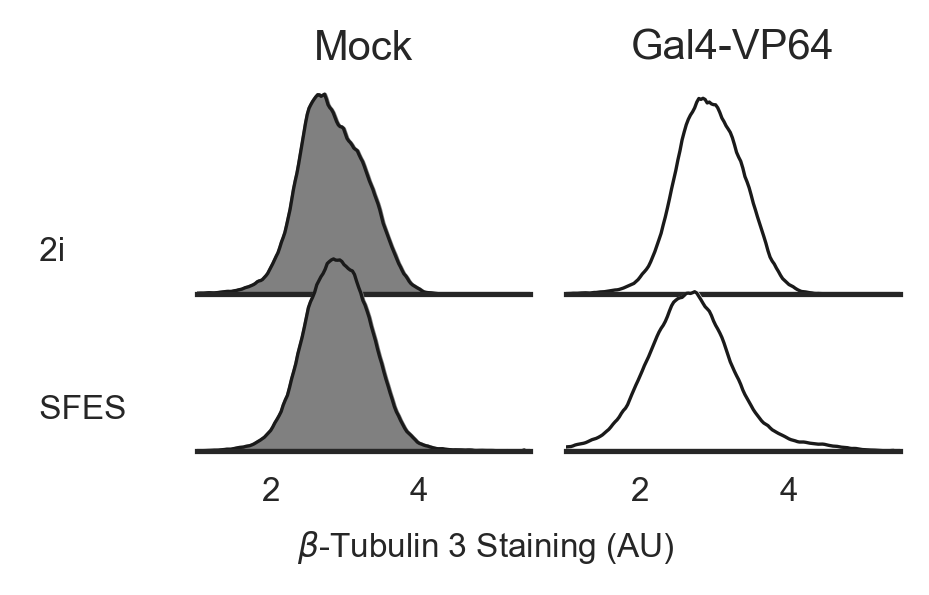

In [14]:
media_order = ['2i', 'SFES']
treatment_order = ['Mock', 'Gal4-VP64']
filters = ((df2['CellLine']=='mESC') &
           (df2['Antibody']=='ab1'))
with sns.color_palette(['gray', '#FFFFFF']):
     g = sns.FacetGrid(data=df2[filters], row='Media', col='Treatment', hue='Treatment',
                       col_order=treatment_order, hue_order=treatment_order, row_order=media_order,
                       height=1, aspect=1.5, xlim=[1, 5.5])
g.map(sns.kdeplot, "logAPC-A", fill=True, alpha=1, bw_adjust=.5, clip=None, cut=0)
g.map(sns.kdeplot, "logAPC-A", color="k", lw=.8, bw_adjust=.5, clip=None, cut=0)
g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)
g.tick_params('x',labelsize=SMALL_SIZE)


for ax in g.axes.flat:
    ax.set(facecolor=(0, 0, 0, 0))
    
for ax in g.axes[:,0]:
    wellname = ax.get_title().split('=')[1].split('|')[0]
    ax.text(-0.5,0.2, "{}".format(wellname), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes, fontsize=SMALL_SIZE)

g.set_titles("")

for ax, cells in zip(g.axes[0,:], treatment_order):
    ax.set_title(cells, y=1, fontsize=MEDIUM_SIZE)
    
g.set(yticks=[])
g.set_xlabels('')
g.set_ylabels('')
g.despine(bottom=False, left=True)
g.fig.supxlabel(r'$\beta$-Tubulin 3 Staining (AU)', fontsize=SMALL_SIZE, y=0.05)
g.fig.set_dpi(300)
plt.savefig(outputdir + 'mesc_gal4_diff_hist.pdf', bbox_inches='tight', dpi=300)

In [15]:
drug = 'all'
filters = ((df2['CellLine']=='iN'))
dist = df2[filters]['logAPC-A'].values[:,np.newaxis]
model = GaussianMixture(3, covariance_type='spherical', random_state=237).fit(dist)
print(f'{drug}: {model.means_}')
on_component = np.argmax(model.means_)
df_summary = (df2[filters]
                   .groupby(['CellLine','Media','Treatment','Replicate'])['logAPC-A']
                   .apply(lambda x: 100*(np.sum(model.predict(x.values[:,np.newaxis])==on_component)/len(x)))
                   .reset_index())
#df_summary = pd.concat(df_summary)

all: [[2.41971773]
 [4.14332381]
 [2.96654963]]


In [17]:
df_summary

,CellLine,Media,Treatment,Replicate,logAPC-A
0,iN,2i,Gal4-VP64,1,8.055893
1,iN,2i,Gal4-VP64,2,7.027117
2,iN,2i,Gal4-VP64,3,5.009992
3,iN,2i,Untransduced,1,0.030738
4,iN,2i,Untransduced,2,0.129122
5,iN,2i,Untransduced,3,0.038101
6,iN,SFES,Gal4-VP64,1,28.818586
7,iN,SFES,Gal4-VP64,2,26.645057
8,iN,SFES,Gal4-VP64,3,22.689582
9,iN,SFES,Untransduced,1,0.350995


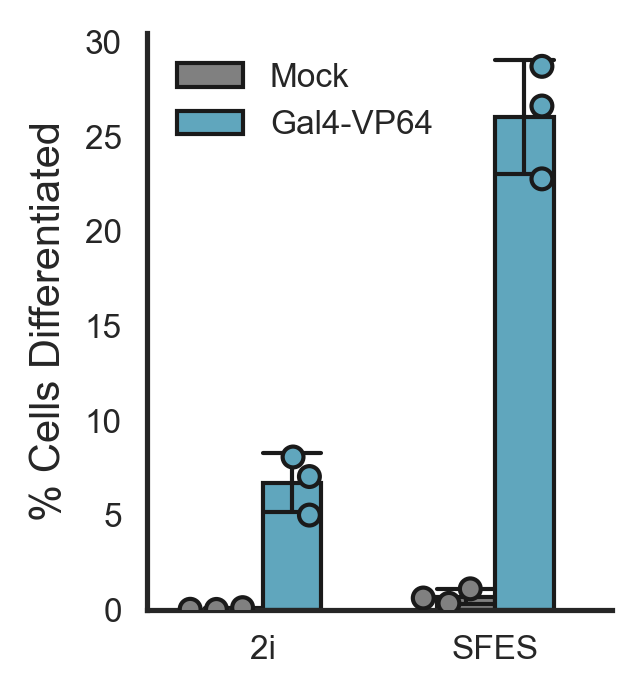

In [16]:
with sns.color_palette(['gray', '#60A6BD']):
    fig, ax = plt.subplots(1,1,figsize=(2,2.5), dpi=300)
    g = sns.swarmplot(data=df_summary, x='Media', y='logAPC-A', hue='Treatment',
                  order=['2i','SFES'],
                  hue_order=['Mock','Gal4-VP64'], 
                  edgecolor='k', linewidth=1, dodge=True, legend=False)
    sns.barplot(data=df_summary, x='Media', y='logAPC-A', hue='Treatment',
                  order=['2i','SFES'],
                  hue_order=['Mock','Gal4-VP64'],
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                estimator='mean', errorbar='sd',
            err_kws={'linewidth': 1, 'color':'k'})
    #g.legend().remove()
    plt.legend(frameon=False)
    g.set_ylabel(r'% Cells Differentiated')
    g.set_xlabel('')
    #plt.xticks(rotation=0, ha='right')
    sns.despine()
    plt.savefig(outputdir+'gal4_diff.pdf', bbox_inches='tight')

In [17]:
filters = ((df2['CellLine']=='mESC') &
           (df2['Antibody']=='ab1'))
df_summary = (df2[filters]
                   .groupby(['CellLine','Media','Treatment','Replicate'])['logAPC-A']
                   .apply(lambda x: 100*(np.sum(model.predict(x.values[:,np.newaxis])==on_component)/len(x)))
                   .reset_index())

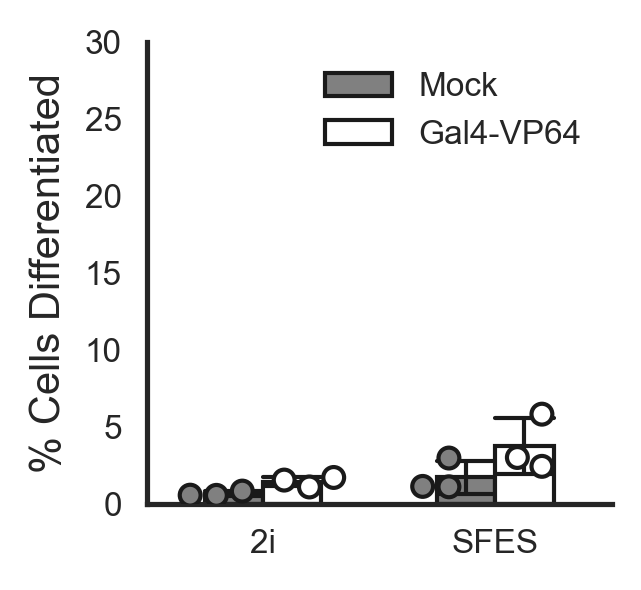

In [18]:
with sns.color_palette(['gray', 'white']):
    fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
    g = sns.swarmplot(data=df_summary, x='Media', y='logAPC-A', hue='Treatment',
                  order=['2i','SFES'],
                  hue_order=['Mock','Gal4-VP64'], 
                  edgecolor='k', linewidth=1, dodge=True, legend=False)
    sns.barplot(data=df_summary, x='Media', y='logAPC-A', hue='Treatment',
                  order=['2i','SFES'],
                  hue_order=['Mock','Gal4-VP64'],
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                estimator='mean', errorbar='sd',
            err_kws={'linewidth': 1, 'color':'k'})
    #g.legend().remove()
    plt.legend(frameon=False)
    g.set_ylabel(r'% Cells Differentiated')
    g.set_xlabel('')
    plt.ylim(0,30)
    #plt.xticks(rotation=0, ha='right')
    sns.despine()
    plt.savefig(outputdir+'mesc_gal4_diff.pdf', bbox_inches='tight')

In [19]:
filters = ((df2['CellLine']=='iN'))
df_summary = (df2[filters]
              .groupby(['CellLine','Media','Treatment','Replicate'])['APC-A']
              .agg(np.mean)
              .reset_index())

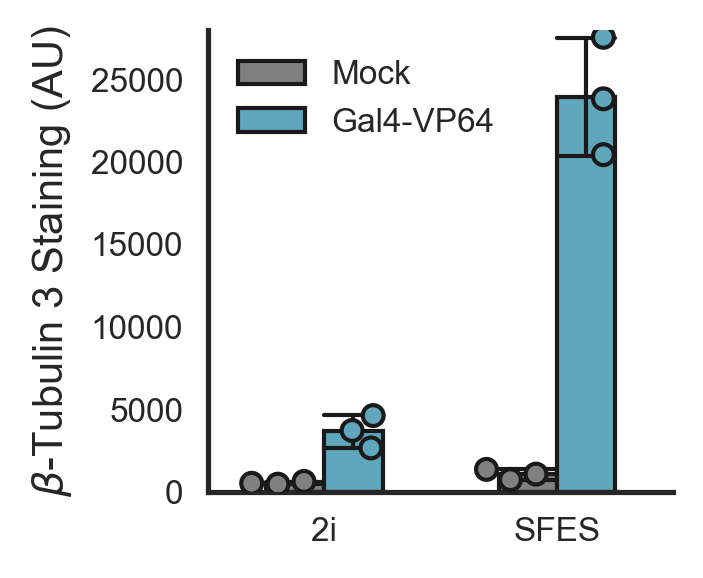

In [20]:
with sns.color_palette(['gray', '#60A6BD']):
    fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
    g = sns.swarmplot(data=df_summary, x='Media', y='APC-A', hue='Treatment',
                  order=['2i','SFES'],
                  hue_order=['Mock','Gal4-VP64'], 
                  edgecolor='k', linewidth=1, dodge=True, legend=False)
    sns.barplot(data=df_summary, x='Media', y='APC-A', hue='Treatment',
                  order=['2i','SFES'],
                  hue_order=['Mock','Gal4-VP64'],
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                estimator='mean', errorbar='sd',
            err_kws={'linewidth': 1, 'color':'k'})
    #g.legend().remove()
    plt.legend(frameon=False)
    g.set_ylabel(r'$\beta$-Tubulin 3 Staining (AU)')
    g.set_xlabel('')
    plt.ylim(0,28000)
    #plt.xticks(rotation=0, ha='right')
    sns.despine()
    plt.savefig(outputdir+'gal4_staining.pdf', bbox_inches='tight')

In [21]:
filters = ((df2['CellLine']=='mESC') &
           (df2['Antibody']=='ab1'))
df_summary = (df2[filters]
              .groupby(['CellLine','Media','Treatment','Replicate'])['APC-A']
              .agg(np.mean)
              .reset_index())

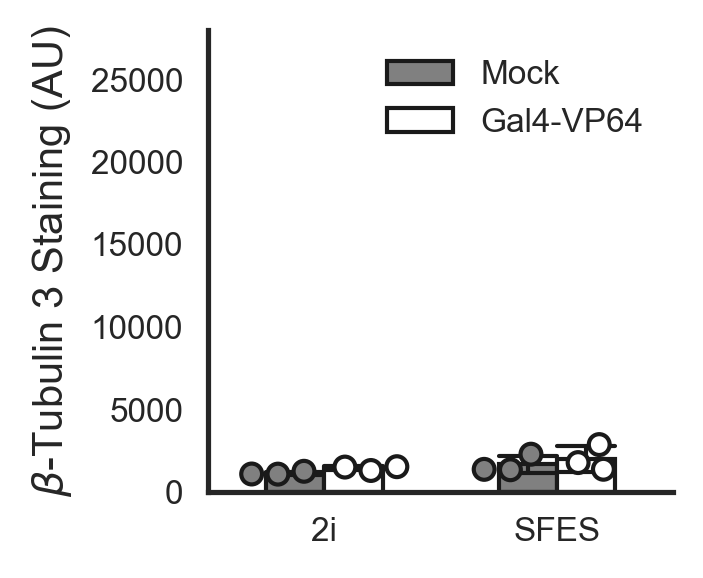

In [22]:
with sns.color_palette(['gray', '#FFFFFF']):
    fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
    g = sns.swarmplot(data=df_summary, x='Media', y='APC-A', hue='Treatment',
                  order=['2i','SFES'],
                  hue_order=['Mock','Gal4-VP64'], 
                  edgecolor='k', linewidth=1, dodge=True, legend=False)
    sns.barplot(data=df_summary, x='Media', y='APC-A', hue='Treatment',
                  order=['2i','SFES'],
                  hue_order=['Mock','Gal4-VP64'],
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                estimator='mean', errorbar='sd',
            err_kws={'linewidth': 1, 'color':'k'})
    #g.legend().remove()
    plt.legend(frameon=False)
    g.set_ylabel(r'$\beta$-Tubulin 3 Staining (AU)')
    g.set_xlabel('')
    plt.ylim(0,28000)
    #plt.xticks(rotation=0, ha='right')
    sns.despine()
    plt.savefig(outputdir+'mesc_gal4_staining.pdf', bbox_inches='tight')